In [1]:
!pip install conllu
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report


In [2]:
from conllu import parse_incr

def load_ud_conllu(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        data = list(parse_incr(f))
    return [[(tok["form"], tok["upos"]) for tok in sent if tok["upos"]] for sent in data]

train_sents = load_ud_conllu("en_ewt-ud-train.conllu")
dev_sents   = load_ud_conllu("en_ewt-ud-dev.conllu")
test_sents  = load_ud_conllu("en_ewt-ud-test.conllu")

In [3]:
word2idx = {'PAD': 0, 'UNK': 1}
tag2idx = {}
for sentence in train_sents:
    for word, tag in sentence:
        word_lower = word.lower()
        if word_lower not in word2idx:
            word2idx[word_lower] = len(word2idx)
        if tag not in tag2idx:
            tag2idx[tag] = len(tag2idx)
idx2tag = {i: t for t, i in tag2idx.items()}


# 2. Encode sentences


In [4]:
def encode(sentence):
    words = [word2idx.get(w.lower(), word2idx['UNK']) for w, _ in sentence]
    tags  = [tag2idx[t] for _, t in sentence]
    return words, tags

train_data_encoded = [encode(s) for s in train_sents]
dev_data_encoded   = [encode(s) for s in dev_sents]
test_data_encoded  = [encode(s) for s in test_sents]

# 3. Pad sequences

In [5]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

PAD_WORD_IDX = word2idx['PAD']  # already defined

def pad_with_mask(data, max_len=None):
    X = [w for w, _ in data]
    y = [t for _, t in data]

    if not max_len:
        max_len = max(len(seq) for seq in X)

    X_pad = pad_sequences(X, maxlen=max_len, padding='post', value=PAD_WORD_IDX)
    # First pad with -1 so we can build the mask
    y_pad_raw = pad_sequences(y, maxlen=max_len, padding='post', value=-1)

    # Build weights: 1 where real tag, 0 where padding
    weights = (y_pad_raw != -1).astype('float32')            # shape: (samples, max_len)

    # Replace -1 with a valid tag index (e.g., 0) so loss sees legal labels
    y_pad = np.where(y_pad_raw == -1, 0, y_pad_raw).astype('int32')  # shape: (samples, max_len)

    # Keras expects (samples, seq_len, 1) for sparse labels
    y_pad = y_pad.reshape((-1, max_len, 1))

    return X_pad.astype('int32'), y_pad, weights, max_len

X_train, y_train, w_train, max_len = pad_with_mask(train_data_encoded)
X_dev,   y_dev,   w_dev,   _       = pad_with_mask(dev_data_encoded, max_len)
X_test,  y_test,  w_test,  _       = pad_with_mask(test_data_encoded, max_len)

print(X_train.shape, y_train.shape, w_train.shape)  # (N, L), (N, L, 1), (N, L)

(12544, 160) (12544, 160, 1) (12544, 160)


# 4. Build BiLSTM model


In [6]:


import tensorflow.keras.backend as K

def masked_accuracy(y_true, y_pred):
    y_true = K.cast(K.squeeze(y_true, axis=-1), 'int32')  # shape: (batch, seq_len)
    y_pred = K.cast(K.argmax(y_pred, axis=-1), 'int32')   # shape: (batch, seq_len)
    mask = K.cast(K.not_equal(y_true, 0), 'float32')       # ignore PAD tag (assumed to be 0)
    matches = K.cast(K.equal(y_true, y_pred), 'float32')
    return K.sum(matches * mask) / K.sum(mask)


model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=200, input_length=max_len, mask_zero=True),  # ↓ from 200
    Bidirectional(LSTM(256, return_sequences=True)),                                           # ↓ from 384
    Dropout(0.4),                                                                               # ↓ from 0.5
    TimeDistributed(Dense(len(tag2idx), activation='softmax'))
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=[masked_accuracy])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# we need to fix the lablel shape because keras need this shape

In [7]:



print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("y_train dtype:", y_train.dtype)
print("Unique values:", np.unique(y_train))


print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)


X_train shape: (12544, 160)
y_train shape: (12544, 160, 1)
y_train dtype: int32
Unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
X_train dtype: int32
y_train dtype: int32


# 5. Train model


In [8]:


from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping


early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

history = model.fit(
    X_train, y_train,
    validation_data=(X_dev, y_dev),  # ✅ keep this
    epochs=15,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler],
    shuffle=True
)

Epoch 1/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 67s 110ms/step - loss: 1.7049 - masked_accuracy: 0.5171 - val_loss: 0.3794 - val_masked_accuracy: 0.9132 - learning_rate: 0.0010
Epoch 2/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 27s 93ms/step - loss: 0.2208 - masked_accuracy: 0.9435 - val_loss: 0.3038 - val_masked_accuracy: 0.9322 - learning_rate: 0.0010
Epoch 3/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - loss: 0.1164 - masked_accuracy: 0.9684 - val_loss: 0.2923 - val_masked_accuracy: 0.9352 - learning_rate: 0.0010
Epoch 4/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - loss: 0.0845 - masked_accuracy: 0.9767 - val_loss: 0.3151 - val_masked_accuracy: 0.9411 - learning_rate: 0.0010
Epoch 5/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 0.0622 - masked_accuracy: 0.9824 - val_loss: 0.3255 - val_masked_accuracy: 0.9403 - learning_rate: 0.0010
Epoch 6/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - loss: 0.0447 - masked_accuracy: 0.9880 - val_loss: 0.3133 - val_masked_accuracy: 0.9388 - learning_rate

# 6. Evaluate on dev set

In [9]:
loss, acc = model.evaluate(X_dev, y_dev)
print("Dev accuracy:", acc)



63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.2831 - masked_accuracy: 0.9361
Dev accuracy: 0.9350311160087585


# 7. Predict and report on test set


65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step
🔍 Classification Report:
              precision    recall  f1-score   support

         ADJ      0.849     0.910     0.878      1788
         ADP      0.937     0.962     0.950      2025
         ADV      0.814     0.884     0.847      1191
         AUX      0.983     0.986     0.985      1543
       CCONJ      0.992     0.992     0.992       736
         DET      0.986     0.987     0.986      1897
        INTJ      0.870     0.777     0.821       121
        NOUN      0.877     0.888     0.882      4123
         NUM      0.912     0.747     0.822       542
        PART      0.963     0.971     0.967       649
        PRON      0.984     0.984     0.984      2165
       PROPN      0.820     0.684     0.746      2075
       PUNCT      0.992     0.987     0.989      3096
       SCONJ      0.845     0.807     0.826       384
         SYM      0.764     0.832     0.797       113
        VERB      0.914     0.944     0.929      2606
           X    

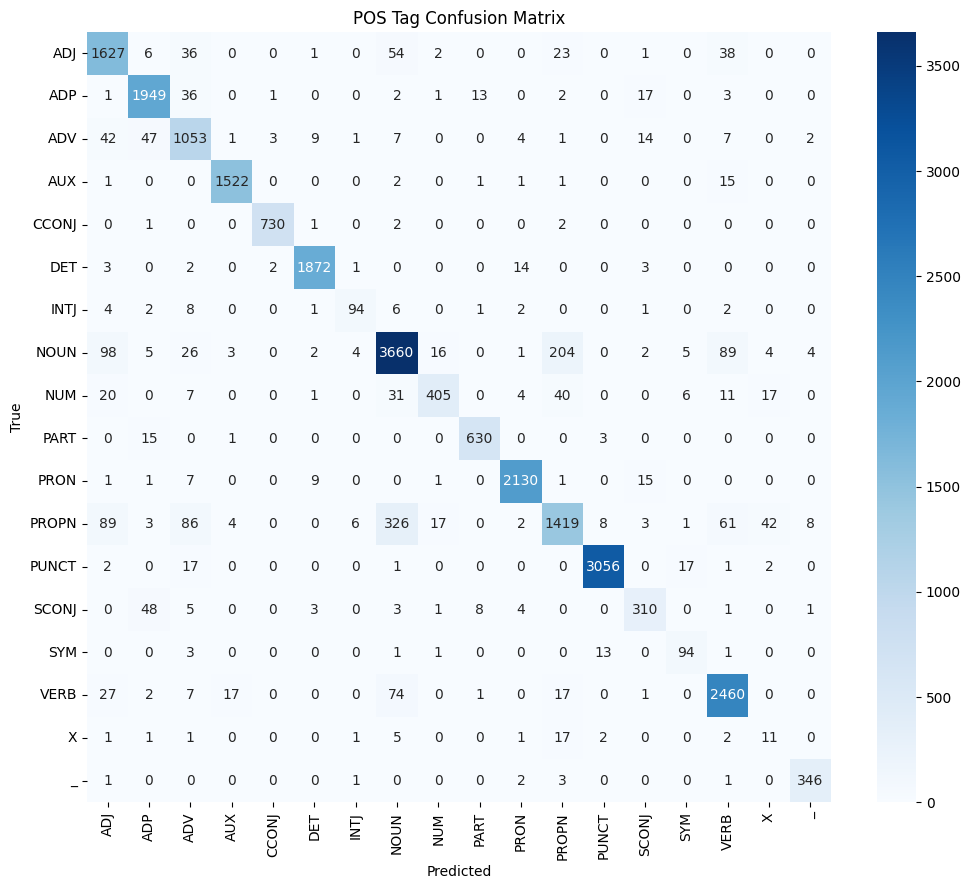

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on test set
y_pred = model.predict(X_test)
y_pred_tags = np.argmax(y_pred, axis=-1)  # shape: (samples, seq_len)

# Flatten predictions and labels, ignoring padding
y_true_flat, y_pred_flat = [], []
for true_seq, pred_seq, w_seq in zip(y_test.squeeze(-1), y_pred_tags, w_test):
    for t, p, w in zip(true_seq, pred_seq, w_seq):
        if w == 1:  # ignore padding
            y_true_flat.append(t)
            y_pred_flat.append(p)

# Convert to tag names
y_true_tags = [idx2tag[i] for i in y_true_flat]
y_pred_tags = [idx2tag[i] for i in y_pred_flat]

# Print classification report
print("🔍 Classification Report:")
print(classification_report(y_true_tags, y_pred_tags, digits=3))

# Plot confusion matrix
tags = sorted(tag2idx.keys())
cm = confusion_matrix(y_true_tags, y_pred_tags, labels=tags)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=tags, yticklabels=tags, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("POS Tag Confusion Matrix")
plt.show()




# apply it on the movie dataset

In [13]:
import json

# Load the JSON file
with open("movies.json", "r", encoding="utf-8") as f:
    script_data = json.load(f)

In [ ]:
print("First few entries in script_data:", script_data[:3])

In [16]:
import torch
import re

# Fallback tokenizer
def simple_tokenize(text):
    return re.findall(r"\b\w+\b|[^\w\s]", text)

# Filter noisy lines
def is_valid_line(line):
    return line.strip() and not line.isupper() and len(line.split()) > 2

# Tokenize and clean script
tokenized_sentences = []
for entry in script_data:
    if isinstance(entry, dict) and "Script" in entry:
        script = entry["Script"]
        lines = script.split("\n")
        for line in lines:
            if is_valid_line(line):
                tokens = simple_tokenize(line)
                tokenized_sentences.append(tokens)

max_len = 50  # adjust based on your training setup


In [19]:
import tensorflow as tf

for sentence in tokenized_sentences[:5]:
    encoded = [word2idx.get(w.lower(), word2idx["UNK"]) for w in sentence]
    padded = encoded + [0] * (max_len - len(encoded))

    input_tensor = tf.convert_to_tensor([padded], dtype=tf.int32)
    output = model(input_tensor)  # shape: [1, max_len, num_tags]

    predicted_indices = tf.argmax(output, axis=-1).numpy()[0][:len(sentence)]
    predicted_tags = [idx2tag[i] for i in predicted_indices]

    # Print vertically aligned output
    print("Sentence:")
    for word, tag in zip(sentence, predicted_tags):
        print(f"{word:<15} {tag}")
    print("*" * 50)



Sentence:
We              PRON
'               PUNCT
re              AUX
watching        VERB
a               DET
pair            NOUN
of              ADP
hands           NOUN
arrange         VERB
white           ADJ
sugar           NOUN
packets         NOUN
,               PUNCT
**************************************************
Sentence:
blue            ADJ
Equal           ADJ
packets         NOUN
,               PUNCT
and             CCONJ
pink            ADJ
Sweet           ADJ
and             CCONJ
Low             ADJ
into            ADP
small           ADJ
**************************************************
Sentence:
containers      NOUN
.               PUNCT
With            ADP
precision       NOUN
and             CCONJ
lightning       VERB
speed           NOUN
,               PUNCT
the             DET
mixed           VERB
up              ADP
**************************************************
Sentence:
colors          NOUN
and             CCONJ
crumpled        VERB
packets       